In [2]:
%%capture
import copy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation

2025-12-02 14:43:52.954357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 14:43:52.954455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 14:43:52.956555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 14:43:52.970347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def load_data():
    (_, _), (test_data, test_labels) = datasets.mnist.load_data()

    test_data = test_data / 255.0
    test_data = test_data[..., tf.newaxis]
    test_data = tf.cast(test_data, tf.float32)

    test_labels = tf.one_hot(test_labels, 10)
    return test_data, test_labels

In [4]:
model_logit = tf.keras.models.load_model('/work/mnist_classifier_model-no-softmax.h5')
xb, yb = load_data()

2025-12-02 14:43:59.632651: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)
2025-12-02 14:44:00.935320: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62720000 exceeds 10% of free system memory.


load les nombres dans l'ordre

In [5]:
x_batch = np.array([xb[10], xb[2], xb[1], xb[32], xb[4], xb[15], xb[21], xb[0], xb[61], xb[9]])
y_batch = np.array([yb[10], yb[2], yb[1], yb[32], yb[4], yb[15], yb[21], yb[0], yb[61], yb[9]])

In [6]:
def loss_func(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

Fonction deepfool (code pour targeted & untargeted en même temps)

In [7]:
def deepfool(image, model, target_class=None, num_classes=10, overshoot=0.02, max_iter=50, shape=(28, 28, 1)):
    image_array = np.array(image)

    image_norm = tf.cast(image_array, tf.float32)
    image_norm = np.reshape(image_norm, shape)
    image_norm = image_norm[tf.newaxis, ...]

    f_image = model(image_norm).numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    orig_label = I[0]
    
    targeted = target_class is not None

    if targeted:
        target = int(target_class)
    else:
        target = None

    input_shape = np.shape(image_norm)
    pert_image = copy.deepcopy(image_norm)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    x = tf.Variable(pert_image)
    fs = model(x)
    k_i = np.argmax(np.array(fs).flatten())

    if targeted:
        # TARGETED: on se concentre sur la frontière entre classe actuelle et classe cible
        while k_i != target and loop_i < max_iter:
            with tf.GradientTape() as tape:
                tape.watch(x)
                fs = model(x)
                # diff entre la classe de base et la classe cible
                current_class = np.argmax(fs[0].numpy())
                loss_value = fs[0, target] - fs[0, current_class]
            
            # Gradient pour réduire la différence
            grad = tape.gradient(loss_value, x)
            
            if grad is None:
                break
            
            # distance jusqu'à la frontiere de decisions
            f_diff = (fs[0, current_class] - fs[0, target]).numpy()
            
            # franchir la frontiere
            grad_norm = np.linalg.norm(grad.numpy().flatten())
            if grad_norm > 1e-8:
                r_i = (abs(f_diff) / grad_norm + 1e-4) * grad / grad_norm
            else:
                break
            
            r_tot = np.float32(r_tot + r_i.numpy())
            
            pert_image = image_norm + (1 + overshoot) * r_tot
            pert_image = np.clip(pert_image, 0, 1)
            
            x = tf.Variable(pert_image)
            fs = model(x)
            k_i = np.argmax(np.array(fs).flatten())
            
            loop_i += 1
    else:
        # logique classique DeepFool, source:  https://github.com/MyRespect/AdversarialAttack/blob/master/deepfool/deepfool_tf.py
        label = orig_label
        while k_i == label and loop_i < max_iter:
            pert = np.inf
            w = np.zeros(input_shape)
            
            with tf.GradientTape() as tape:
                tape.watch(x)
                fs = model(x)
                loss_value = fs[0, I[0]]
            grad_orig = tape.gradient(loss_value, x)

            for k in range(1, num_classes):
                with tf.GradientTape() as tape:
                    tape.watch(x)
                    fs = model(x)
                    loss_value = fs[0, I[k]]
                
                cur_grad = tape.gradient(loss_value, x)
                w_k = cur_grad - grad_orig
                f_k = (fs[0, I[k]] - fs[0, I[0]]).numpy()

                pert_k = abs(f_k) / (np.linalg.norm(tf.reshape(w_k, [-1])) + 1e-8)

                if pert_k < pert:
                    pert = pert_k
                    w = w_k

            r_i = (pert + 1e-4) * w / (np.linalg.norm(w) + 1e-8)
            r_tot = np.float32(r_tot + r_i)

            pert_image = image_norm + (1 + overshoot) * r_tot
            pert_image = np.clip(pert_image, 0, 1)

            x = tf.Variable(pert_image)
            fs = model(x)
            k_i = np.argmax(np.array(fs).flatten())

            loop_i += 1

    r_tot = (1 + overshoot) * r_tot

    return r_tot, loop_i, orig_label, k_i, pert_image

## Untargeted

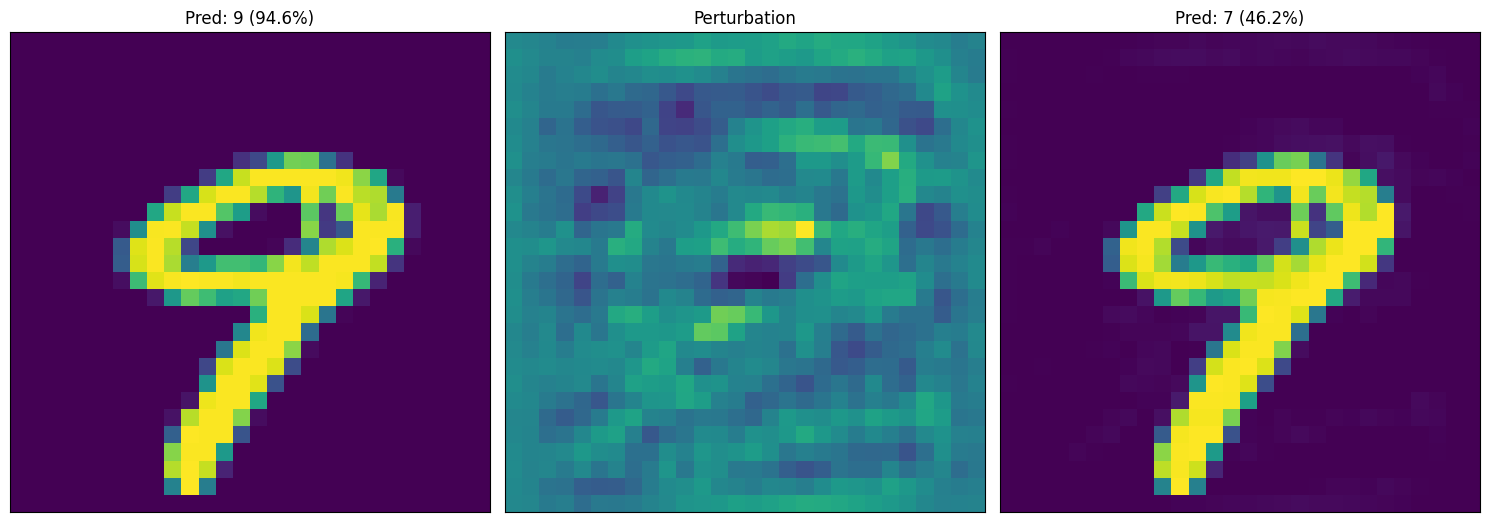

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 20))
axes = axes.flatten()

image = x_batch[9]

r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model_logit, target_class=None, overshoot=0.02, max_iter=50)

image_pred = model_logit.predict(np.array(image)[np.newaxis, ...], verbose=0)
image_pred_softmax = tf.nn.softmax(image_pred).numpy()

r_pred = model_logit.predict(r, verbose=0)
r_pred_softmax = tf.nn.softmax(r_pred).numpy()

pert_pred = model_logit.predict(pert_image, verbose=0)
pert_pred_softmax = tf.nn.softmax(pert_pred).numpy()



axes[0].imshow(image)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title(f'Pred: {np.argmax(image_pred_softmax)} ({image_pred_softmax[0, np.argmax(image_pred_softmax)]*100:.1f}%)')

axes[1].imshow(r.reshape(28,28))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(f'Perturbation')

axes[2].imshow(pert_image.reshape(28,28))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title(f'Pred: {np.argmax(pert_pred_softmax)} ({pert_pred_softmax[0, np.argmax(pert_pred_softmax)]*100:.1f}%)')

plt.tight_layout()
plt.show()

## Targeted

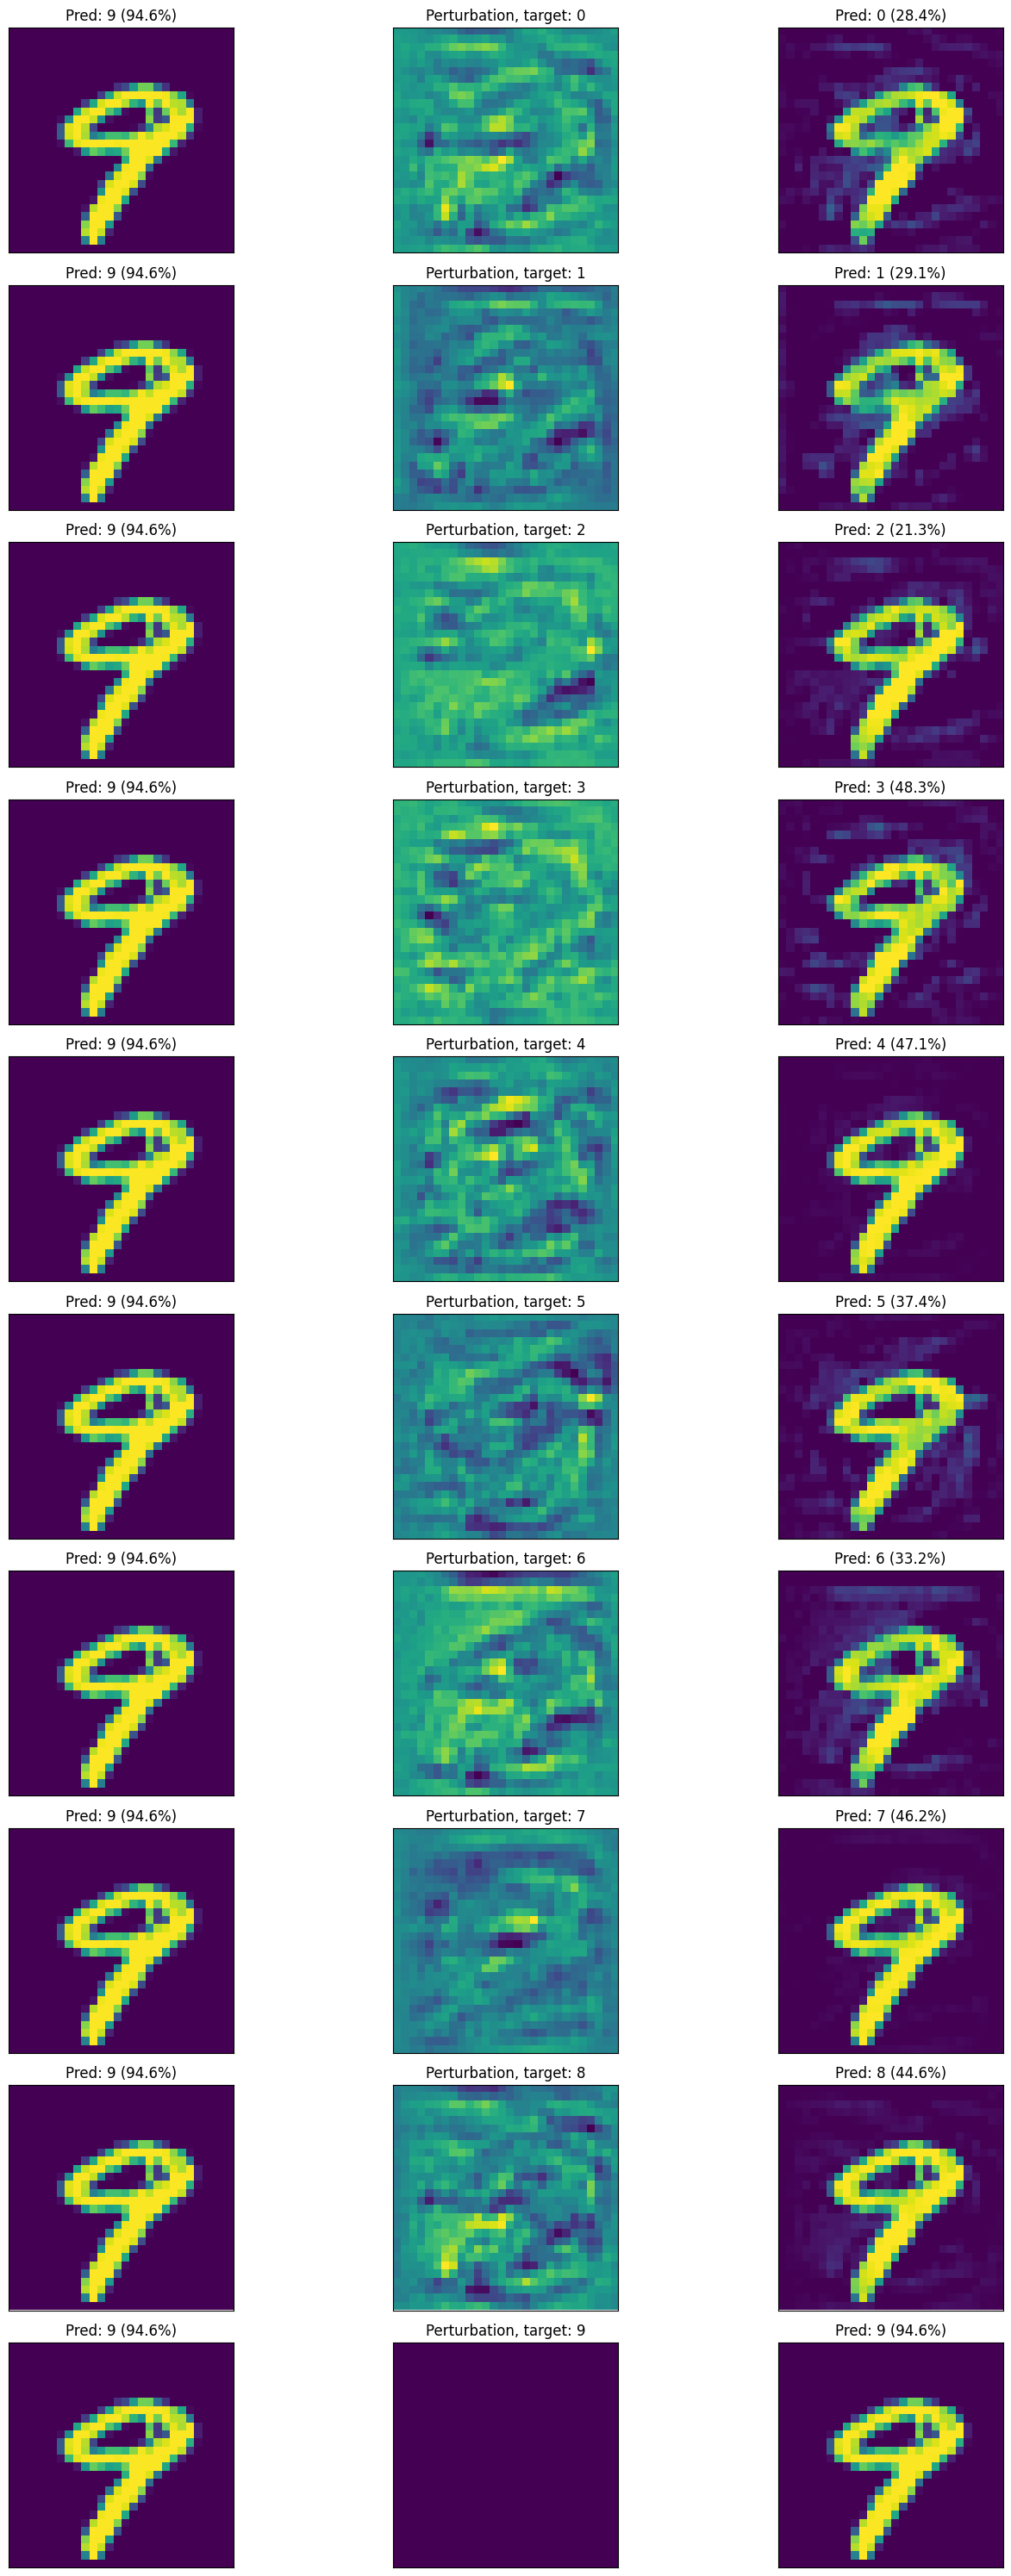

In [9]:
fig, axes = plt.subplots(10, 3, figsize=(15, 30))
axes = axes.flatten()

for lab in range(10):
    image = x_batch[9]

    r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model_logit, target_class=lab, overshoot=0.02, max_iter=50)

    image_pred = model_logit.predict(np.array(image)[np.newaxis, ...], verbose=0)
    image_pred_softmax = tf.nn.softmax(image_pred).numpy()

    r_pred = model_logit.predict(r, verbose=0)
    r_pred_softmax = tf.nn.softmax(r_pred).numpy()

    pert_pred = model_logit.predict(pert_image, verbose=0)
    pert_pred_softmax = tf.nn.softmax(pert_pred).numpy()



    axes[lab*3 + 0].imshow(image)
    axes[lab*3 + 0].set_xticks([])
    axes[lab*3 + 0].set_yticks([])
    axes[lab*3 + 0].set_title(f'Pred: {np.argmax(image_pred_softmax)} ({image_pred_softmax[0, np.argmax(image_pred_softmax)]*100:.1f}%)')

    axes[lab*3 + 1].imshow(r.reshape(28,28))
    axes[lab*3 + 1].set_xticks([])
    axes[lab*3 + 1].set_yticks([])
    axes[lab*3 + 1].set_title(f'Perturbation, target: {lab}')

    axes[lab*3 + 2].imshow(pert_image.reshape(28,28))
    axes[lab*3 + 2].set_xticks([])
    axes[lab*3 + 2].set_yticks([])
    axes[lab*3 + 2].set_title(f'Pred: {np.argmax(pert_pred_softmax)} ({pert_pred_softmax[0, np.argmax(pert_pred_softmax)]*100:.1f}%)')

plt.tight_layout()
plt.show()

In [10]:
image = x_batch[0]

%timeit r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model_logit, overshoot=0.05, max_iter=50)

1.65 s ± 61.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


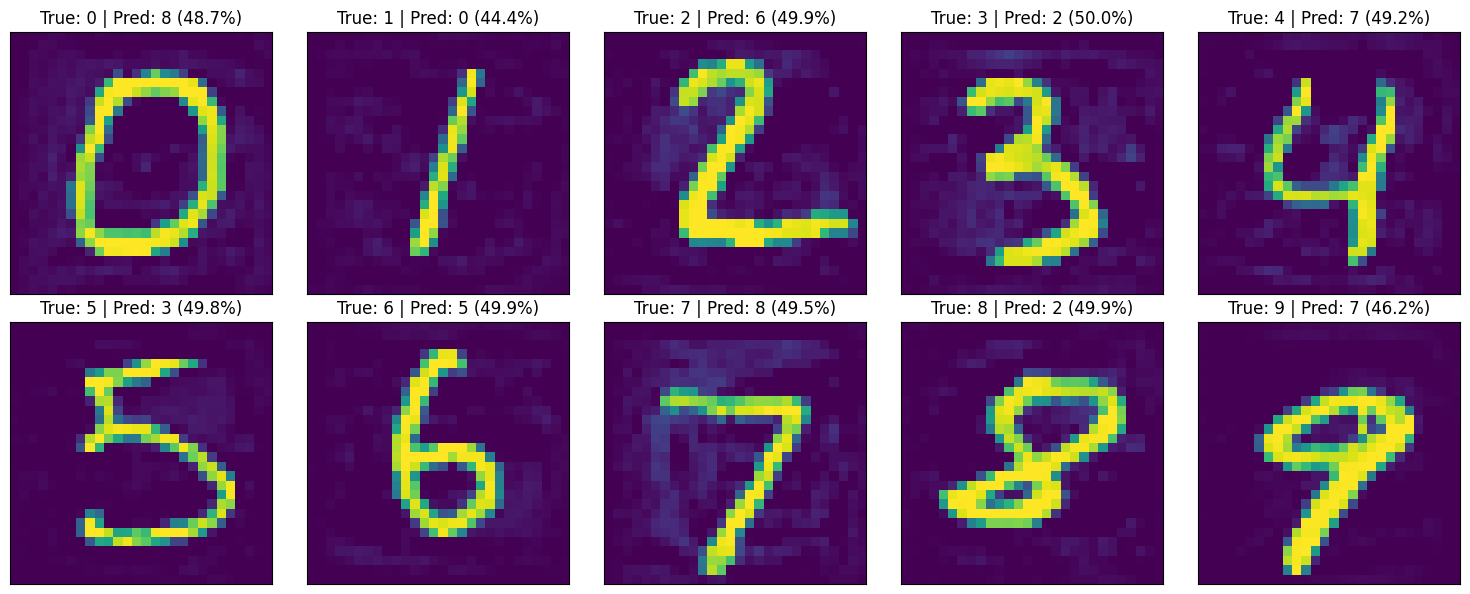

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):

    image = x_batch[i]

    r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model_logit, overshoot=0.05, max_iter=50)

    pert_pred = model_logit.predict(pert_image, verbose=0)
    pert_pred_softmax = tf.nn.softmax(pert_pred).numpy()

    axes[i].imshow(pert_image.reshape(28,28))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'True: {np.argmax(y_batch[i])} | Pred: {np.argmax(pert_pred_softmax)} ({pert_pred_softmax[0, np.argmax(pert_pred_softmax)]*100:.1f}%)')

plt.tight_layout()
plt.show()

In [12]:
#attack_success_by_digit = {i: [] for i in range(10)}

possible d'optimiser: si à l'itération précédente, le succès était de 100, forcément qu'à la suivante il sera de 100

In [13]:
"""
max_iter_values = range(1, 30)

n_img_test = 50


for max_iter in max_iter_values:
    break # couper le code
    print("\n", max_iter, end=": ", flush=True)
    for target_digit in range(10):
        print(target_digit, end=" ", flush=True)
        
        # Find images of the target digit
        target_indices = np.where(np.argmax(y_batch, axis=1) == target_digit)[0]
        
        # Test attack success on these images
        successful_attacks = 0
        
        for idx in target_indices[:n_img_test]:
            image = x_batch[idx]
            _, _, label_orig, label_pert, _ = deepfool(image, model_logit, overshoot=0.05, max_iter=max_iter)
            
            if label_orig != label_pert:
                successful_attacks += 1
        
        success_rate = (successful_attacks / n_img_test) * 100
        attack_success_by_digit[target_digit].append(success_rate)
    if max_iter == 15:
        print(attack_success_by_digit)
"""

'\nmax_iter_values = range(1, 30)\n\nn_img_test = 50\n\n\nfor max_iter in max_iter_values:\n    break # couper le code\n    print("\n", max_iter, end=": ", flush=True)\n    for target_digit in range(10):\n        print(target_digit, end=" ", flush=True)\n        \n        # Find images of the target digit\n        target_indices = np.where(np.argmax(y_batch, axis=1) == target_digit)[0]\n        \n        # Test attack success on these images\n        successful_attacks = 0\n        \n        for idx in target_indices[:n_img_test]:\n            image = x_batch[idx]\n            _, _, label_orig, label_pert, _ = deepfool(image, model_logit, overshoot=0.05, max_iter=max_iter)\n            \n            if label_orig != label_pert:\n                successful_attacks += 1\n        \n        success_rate = (successful_attacks / n_img_test) * 100\n        attack_success_by_digit[target_digit].append(success_rate)\n    if max_iter == 15:\n        print(attack_success_by_digit)\n'

In [14]:
"""
# Plot results
plt.figure(figsize=(12, 7))
max_iter_values = range(1, 30, 1)


for digit in range(10):
    plt.plot(max_iter_values, attack_success_by_digit[digit], label=f'Classe n°{digit}')

plt.xlabel('Iterations max')
plt.ylabel('Précision %')
plt.title('Précision en fonction du nombre d\'itérations max')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.show()
"""

"\n# Plot results\nplt.figure(figsize=(12, 7))\nmax_iter_values = range(1, 30, 1)\n\n\nfor digit in range(10):\n    plt.plot(max_iter_values, attack_success_by_digit[digit], label=f'Classe n°{digit}')\n\nplt.xlabel('Iterations max')\nplt.ylabel('Précision %')\nplt.title('Précision en fonction du nombre d'itérations max')\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.ylim(0, 105)\nplt.show()\n"

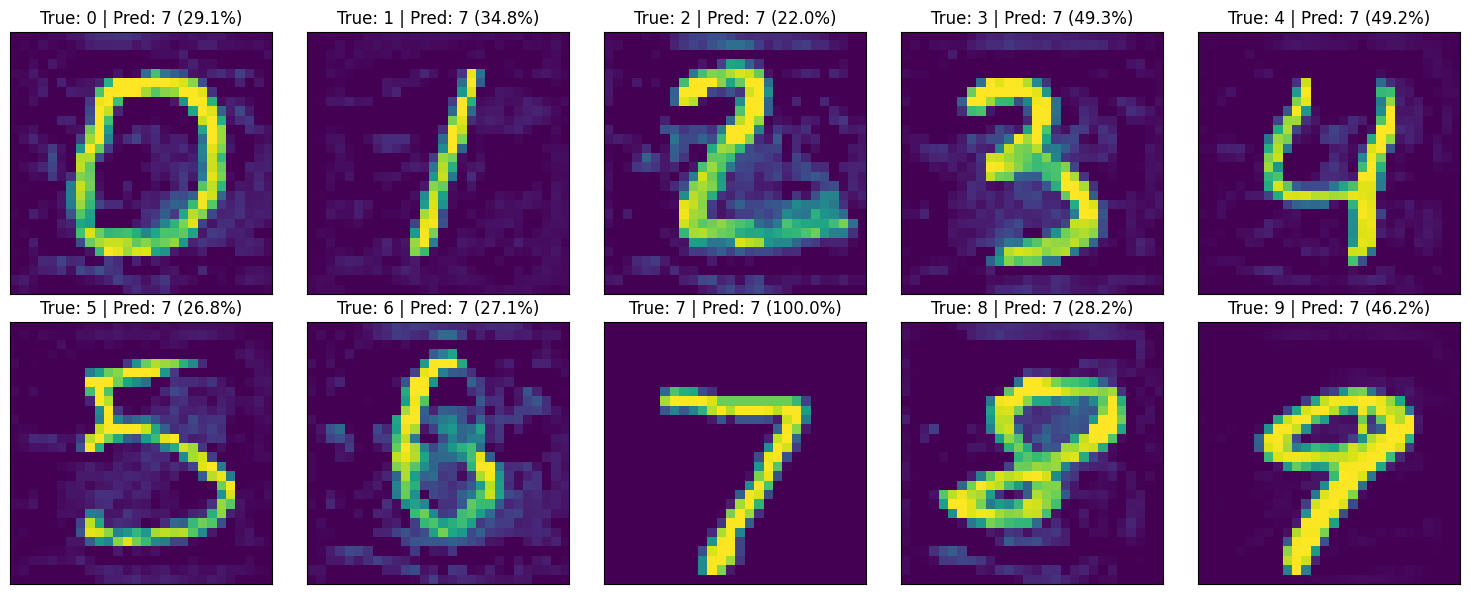

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):

    image = x_batch[i]

    r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model_logit, target_class=7, overshoot=0.02, max_iter=50)

    pert_pred = model_logit.predict(pert_image, verbose=0)
    pert_pred_softmax = tf.nn.softmax(pert_pred).numpy()

    axes[i].imshow(pert_image.reshape(28,28))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'True: {np.argmax(y_batch[i])} | Pred: {np.argmax(pert_pred_softmax)} ({pert_pred_softmax[0, np.argmax(pert_pred_softmax)]*100:.1f}%)')

plt.tight_layout()
plt.show()

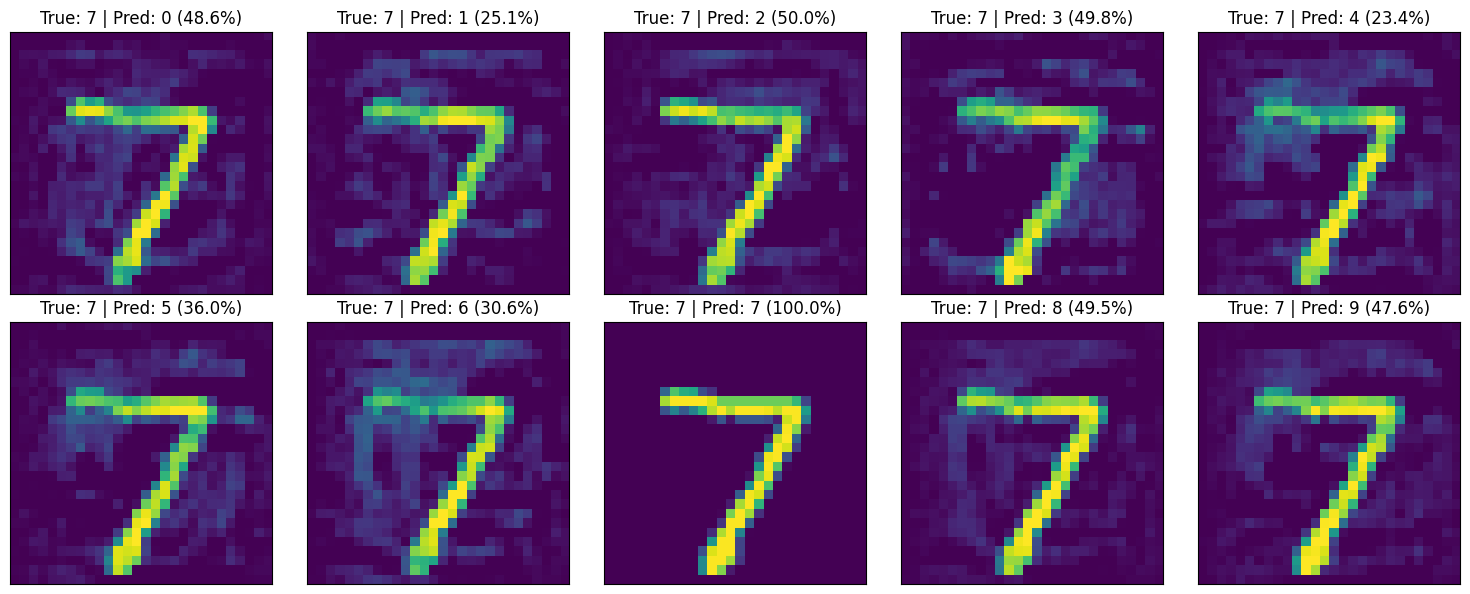

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):

    image = x_batch[7]

    r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model_logit, target_class=i, overshoot=0.02, max_iter=50)

    pert_pred = model_logit.predict(pert_image, verbose=0)
    pert_pred_softmax = tf.nn.softmax(pert_pred).numpy()

    axes[i].imshow(pert_image.reshape(28,28))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'True: 7 | Pred: {np.argmax(pert_pred_softmax)} ({pert_pred_softmax[0, np.argmax(pert_pred_softmax)]*100:.1f}%)')

plt.tight_layout()
plt.show()